In [152]:
## import pakages (deleted packages part)
df = pd.read_csv('flights_2008.csv')
pd.set_option('display.max_columns', None)
df=df.rename(columns={'Unnamed: 0':'ID'})
df=df.set_index('ID',verify_integrity=True)

print(df.shape)
# df.head()

(1936758, 29)


## Preprocessing

In [6]:
# Downsize the datasize, only use the flight dataset from YV company
df_YV=df[df['UniqueCarrier']=='YV'].reset_index(drop=True)

# Transfer Time to classfication(dawn,morining,afternoon,evening)
for i in ['DepTime','CRSDepTime','ArrTime','CRSArrTime']:
    df_YV[i+'_period']=pd.cut(df_YV[i],bins=[0,600,1200,1800,2400],
    labels=['dawn','morning','afternoon','evening'],right=False).astype("object")
    
# Create binary variables to show a specific delay
for i in ['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']:
    df_YV[i]=df_YV[i].apply(np.nan_to_num)
    df_YV[i+'_or_not']=df_YV[i].apply(lambda x:0 if x==0 else 1)
    
# Based on Origin and Dest counts, calculate the main airports 
# And then create binary airport attributes base on major airports.
Major_Airports=['ATL','BWI','BOS','CLT','MDW','ORD','DFW','DEN','DTW',
                'FLL','HNL','IAH','LAS','LAX','MIA','MSP','JFK','LGA','EWR','MCO','PHL','PHX',
                'PDX','SLC','SAN','SFO','SEA','TPA','DCA','IAD']
df_YV['Dest_Major']=df_YV['Dest'].isin(Major_Airports).replace([True,False],[1,0])
df_YV['Origin_Major']=df_YV['Origin'].isin(Major_Airports).replace([True,False],[1,0])

# The average delay time for flights is 12.4 minutes, 
# There is a 15-minute “grace period”, we regard delay time more than 15 mins as delayed.
# Transfer DepDelay to classification variable
df_YV['DepDelay']=pd.cut(df_YV['DepDelay'],bins=[0,15,float('+inf')],labels=[0,1])
df_YV['ArrDelay']=pd.cut(df_YV['ArrDelay'],bins=[float('-inf'),15,float('+inf')],labels=[0,1])

# Drop cancelled flights since they might have delayed variables
df_YV=df_YV.drop(df_YV[df_YV['Cancelled']==1].index).reset_index(drop=True)

# Fill some Na list with 0
na_lst=['ActualElapsedTime','AirTime','TaxiIn','TaxiOut','ArrDelay','DepDelay']
df_YV[na_lst]=df_YV[na_lst].fillna(value=0)

df_YV.to_csv('df_YV.csv',index=False)

In [43]:
# Set y,x
y = df_YV['ArrDelay'] 
X = df_YV.drop(['Year','DepTime','ActualElapsedTime','ArrTime',
'TailNum','Origin','Dest','CancellationCode','DepDelay','ArrDelay','CarrierDelay',
'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay','UniqueCarrier','Cancelled',
'DepTime_period','ArrTime_period', 'ArrTime_period','NASDelay_or_not', 
'SecurityDelay_or_not', 'LateAircraftDelay_or_not','TaxiIn','TaxiOut'],axis=1)
X.reset_index()

# Fillna CRSElapsedTime missing value to mean (consider missing)
mean = np.nanmean(df_YV['CRSElapsedTime'])
X['CRSElapsedTime']=X['CRSElapsedTime'].fillna(mean)

# Get dummy variables
for column in X.columns:
    if X[column].dtype == np.object:
        X = pd.concat([X,pd.get_dummies(X[column], prefix=column,drop_first=True)],axis=1).drop([column],axis=1)

<ipython-input-43-154cc6b11052>:16: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if X[column].dtype == np.object:


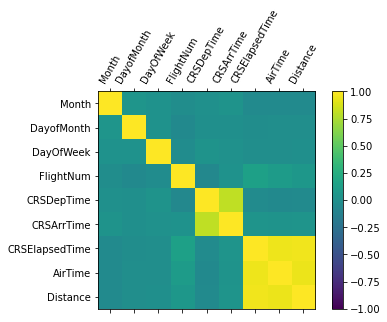

In [44]:
# Find the high correlation between attributes and remove them
X_correlation=X[['Month','DayofMonth','DayOfWeek','FlightNum','CRSDepTime', 'CRSArrTime',
                 'CRSElapsedTime','AirTime','Distance']]

def corr_fig(correlation,data):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlation, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(data.columns),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    for tick in ax.get_xticklabels():
        tick.set_rotation(60)

    ax.set_xticklabels(data.columns)
    ax.set_yticklabels(data.columns)
    plt.show()
    
corr_fig(X_correlation.corr(),X_correlation)

In [45]:
# print the correlation coefficient and drop variables which are more than 0.5
#print(X_correlation.corr(method='pearson'))
X=X.drop(['CRSElapsedTime','CRSArrTime','AirTime','CRSDepTime'],axis=1)
X=X.reset_index(drop=True)

In [ ]:
# Standardardlisation and Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=11)
to_standard=['Month','DayofMonth','DayOfWeek','FlightNum','Distance']
ss=StandardScaler()
X_train[to_standard] = ss.fit_transform(X_train[to_standard])
X_test[to_standard] = ss.transform(X_test[to_standard])

In [47]:
def evaluation_metrics(y_test,prediction):
    a=accuracy_score(y_test,prediction) # accuracy
    b=recall(y_test,prediction)
    c=precision(y_test,prediction)
    d=f1(y_test,prediction)
    return {'Accuracy':a,'Recall':b,'Precision':c,'F1':d}

## Penalized (LASSO) Logistic Regression 

In [ ]:
# Logistic Regression
classifier = LogisticRegression()
hypeparameters={'penalty':['l1','l2'],'C':np.logspace(0,4,10),'solver':['saga']}
gridsearch = GridSearchCV(classifier,hypeparameters,cv=5,scoring='roc_auc',verbose=0,n_jobs=-1)
best_logit_model=gridsearch.fit(X_train,y_train)
best_parameter={key:value for key,value in best_logit_model.best_estimator_.get_params().items() if key in ['C','penalty','solver']}
print(best_parameter)
# {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}

In [58]:
logistic_regression=LogisticRegression(C=best_parameter['C'],penalty=best_parameter['penalty'], solver=best_parameter['solver'])
LR_model=logistic_regression.fit(X_train,y_train.values.ravel())
prediction = LR_model.predict(X_test)
rmse_tuned = str(sqrt(mse(y_test,prediction)))

print(evaluation_metrics(y_test,prediction))
print('AUC:',roc_auc_score(y_test,prediction1))
print('RMSE:', rmse_tuned)

{'Accuracy': 0.7963985474804756, 'Recall': 0.8941524796447077, 'Precision': 0.8405870445344129, 'F1': 0.8665427630506374}
AUC: 0.7906176723842133
RMSE: 0.4512221764491684


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [46]:
cv_score = gridsearch.best_score_
test_score = gridsearch.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.9776204086012392
Test score: 0.9733749584506622


In [ ]:
plt.figure()
plt.title("Logistic Regression's Features Coefficient")
plt.barh(X.columns,LR_model.coef_[0])
plt.show()

## Decision Tree

In [54]:
hypeparameters={'max_depth':range(2,6),'min_samples_leaf':[10,20],'class_weight':['balanced']}
decision_tree = DecisionTreeClassifier(random_state=1,criterion='entropy')
grid_search=GridSearchCV(decision_tree,hypeparameters,cv=5,scoring='roc_auc',verbose=0,n_jobs=-1)
best_classifier=grid_search.fit(X_train,y_train)
best_parameter={key:value for key,value in best_classifier.best_estimator_.get_params().items() 
                if key in ['max_depth','min_samples_leaf','class_weight']}
print(best_parameter)

{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 10}


In [55]:
decision_tree = DecisionTreeClassifier(max_depth=best_parameter['max_depth'],
                                       min_samples_leaf=best_parameter['min_samples_leaf'],
                                       class_weight=best_parameter['class_weight'],
                                     random_state=1,criterion='entropy')
decision_tree.fit(X_train,y_train)
prediction1 = decision_tree.predict(X_test)
rmse_tuned = str(sqrt(mse(y_test,prediction1)))
print(evaluation_metrics(y_test,prediction1))
print('AUC:',roc_auc_score(y_test,prediction1))
print('RMSE:', rmse_tuned)
print('Number of nodes:', decision_tree.tree_.node_count)

{'Accuracy': 0.7140725264885838, 'Recall': 0.6306439674315322, 'Precision': 0.9731076731388225, 'F1': 0.7653111219990201}
AUC: 0.7906176723842133
RMSE: 0.5347218655632255
Number of nodes: 55


In [59]:
cv_score = gridsearch.best_score_
test_score = gridsearch.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.8575501439705985
Test score: 0.852919516349406


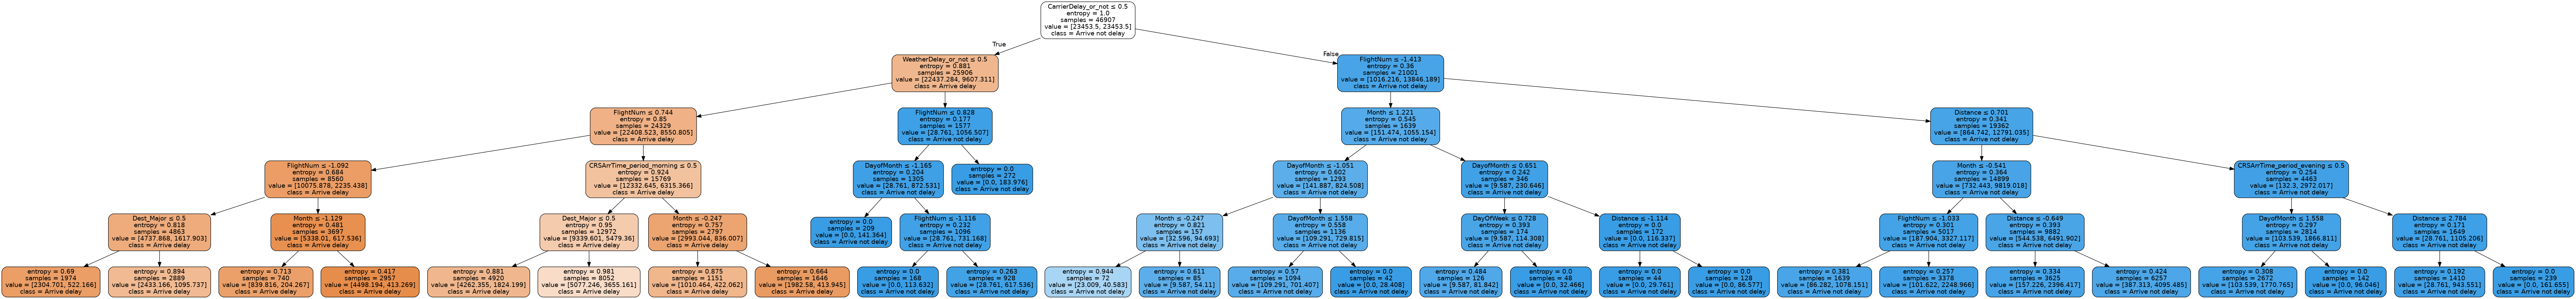

In [60]:
# create a file to store the figure in
dot_data = StringIO()
export_graphviz(decision_tree, out_file=dot_data,filled=True,
                rounded=True,class_names=['Arrive delay','Arrive not delay'],
                special_characters=True,feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [ ]:
# decision tree's features importances
plt.figure(figsize=(5,4))
plt.title("Decision Tree's Features Importances")
plt.barh(X.columns,decision_tree.feature_importances_)
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, prediction1)
plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC')
plt.title('ROC curve')
plt.show()

## Random Forest

In [65]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train.values.ravel())
prediction2 = rf.predict(X_test)
prediction_prob = rf.predict_proba(X_test)
rmse_tuned = str(sqrt(mse(y_test,prediction2)))
print(evaluation_metrics(y_test,prediction2))
print('AUC:',roc_auc_score(y_test,prediction_prob[:,1]))
print('RMSE:', rmse_tuned)

{'Accuracy': 0.8233596975575784, 'Recall': 0.9006123410268488, 'Precision': 0.8658299909432009, 'F1': 0.8828787229130248}
AUC: 0.8769255536251087
RMSE: 0.42028597697570347


In [ ]:
# Random Forest
plt.figure(figsize=(5,4))
plt.title("Random Forest's Features Importances")
plt.barh(X.columns,rf.feature_importances_)
plt.show()

## SVC

In [68]:
# The gamma parameter is the kernel coefficient for kernels rbf/poly/sigmoid (more on this later)
svm = SVC(gamma='auto')

svc=svm.fit(X_train,y_train.values.reshape(-1))
prediction3 = svm.predict(X_test)
rmse_tuned = str(sqrt(mse(y_test,prediction3)))
print(evaluation_metrics(y_test,prediction3))
# print('Accuracy:', accuracy_score(y_test,prediction3))
print('AUC:',roc_auc_score(y_test,prediction3))
print('RMSE:', rmse_tuned)

{'Accuracy': 0.7997313833756156, 'Recall': 0.9110423255500976, 'Precision': 0.8335282891091547, 'F1': 0.8705632716049382}
Accuracy: 0.7997313833756156
AUC: 0.6976043371359798
RMSE: 0.4475138172440985


## Prediction

In [110]:
def predict_output(predict_v,title):
    if predict_v in X.columns:
        pred_output = X_test.copy().drop(columns = [predict_v])
    else:
        pred_output = X_test.copy()
    predc = pd.merge(pred_output, df_YV[[predict_v]],left_index=True,right_index=True)
    predc["ArrDelay"] = prediction2
    predc = predc[predc['ArrDelay']==1]
    flightnum = predc[predict_v].value_counts()[0:10]
    flightnum.plot(kind = 'bar', title=title)
    # plt.gca().invert_xaxis()

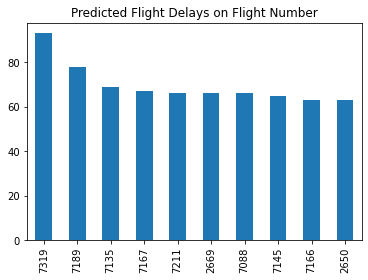

In [111]:
predict_output('FlightNum','Predicted Flight Delays on Flight Number')

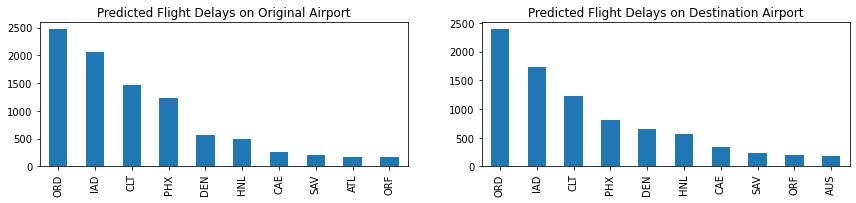

In [113]:
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplot(1,2,1)
predict_output('Origin','Predicted Flight Delays on Original Airport')
plt.subplot(1,2,2)
predict_output('Dest','Predicted Flight Delays on Destination Airport')

plt.subplots_adjust(left=0.125, bottom=0.7, right=2,  top=1.2,  wspace=0.2,hspace=0.55)

# fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.show()

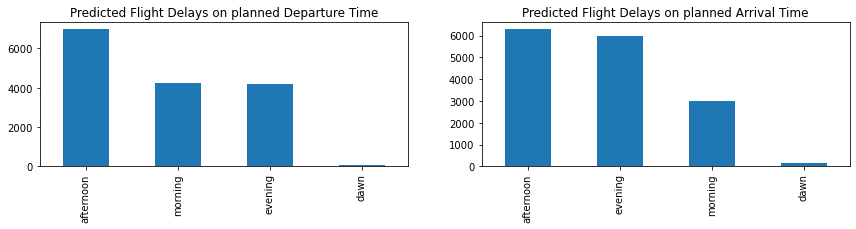

In [116]:
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplot(1,2,1)
predict_output('CRSDepTime_period','Predicted Flight Delays on planned Departure Time')
plt.subplot(1,2,2)
predict_output('CRSArrTime_period','Predicted Flight Delays on planned Arrival Time')

plt.subplots_adjust(left=0.125, bottom=0.7, right=2,  top=1.2,  wspace=0.2,hspace=0.55)

# fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.show()

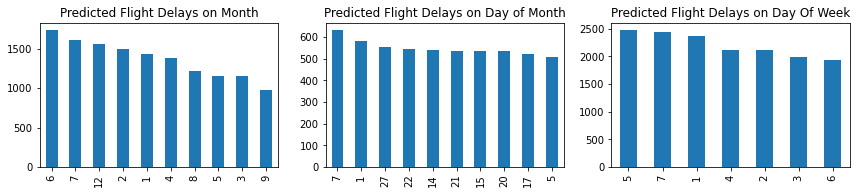

In [118]:
fig, axes = plt.subplots(nrows=1, ncols=3)
plt.subplot(1,3,1)
predict_output('Month','Predicted Flight Delays on Month')
plt.subplot(1,3,2)
predict_output('DayofMonth','Predicted Flight Delays on Day of Month')
plt.subplot(1,3,3)
predict_output('DayOfWeek','Predicted Flight Delays on Day Of Week')

plt.subplots_adjust(left=0.125, bottom=0.7, right=2,  top=1.2,  wspace=0.2,hspace=0.55)

In [146]:
fn=[7189,7135,7167]
count_series=df_YV[df_YV.FlightNum.isin(fn)].groupby(['FlightNum','Origin', 'Dest','CRSDepTime_period', 'CRSArrTime_period']).size()
count_groupby = count_series.to_frame(name = 'count').reset_index()
count_groupby.to_csv('count.csv')

In [154]:
## show top 3 flights count
count_groupby

,FlightNum,Origin,Dest,CRSDepTime_period,CRSArrTime_period,count
0,7135,CLE,IAD,evening,evening,115
1,7135,IAD,CLE,afternoon,evening,159
2,7135,MLI,ORD,morning,afternoon,7
3,7135,ORD,MLI,morning,morning,6
4,7167,CAE,IAD,afternoon,afternoon,133
5,7167,GSO,ORD,afternoon,afternoon,28
6,7167,IAD,CAE,afternoon,afternoon,89
7,7167,ORD,GSO,morning,morning,22
8,7189,CLT,IAD,evening,evening,136
9,7189,IAD,CLT,afternoon,evening,125
